To make a meaningful comparison I think I need to know more about my source behaviour. However I can still get a point spread function

In [1]:
from ParticleTracerClass import ParticleTracer
from phaseSpaceAnalyzer import SwarmSnapShot
import dill
from tqdm import tqdm
import time
from SwarmTracerClass import SwarmTracer
import warnings
import numpy as np
from ParticleClass import Swarm
from ParticleClass import Particle as ParticleBase
from ParticleTracerLatticeClass import ParticleTracerLattice
import matplotlib.pyplot as plt
import pathos as pa


LObject=70.0E-2
LImage=85E-2
LLensHardEdge=15.24e-2
rpLens=(5e-2,7.5e-2)
magnetWidth=(.0254,.0254*1.5)

fringeFrac=1.5
LFringe=fringeFrac*max(rpLens)
LLens=LLensHardEdge+2*LFringe
LObject-=LFringe
LImage-=LFringe

PTL=ParticleTracerLattice(v0Nominal=210.0,latticeType='injector',parallel=True)
PTL.add_Drift(LObject,ap=.07)
PTL.add_Halbach_Lens_Sim(rpLens,LLens,apFrac=.8,dipolesPerDim=4,magnetWidth=magnetWidth)
PTL.add_Drift(LImage*2,ap=.07)
assert PTL.elList[1].fringeFracOuter==fringeFrac and abs(PTL.elList[1].Lm-LLensHardEdge)<1e-9
PTL.end_Lattice()

# file=open('collectorLensLattice','wb')
# dill.dump(PTL,file)
# file=open('collectorLensLattice','rb')
# PTL=dill.load(file)
# file.close()

# Interpolation function

In [2]:
class Interpolater:
    def __init__(self,swarm,PTL):
        self.swarm=swarm
        self.PTL=PTL
        self.endDriftLength=abs(self.PTL.elList[-1].r2[0]-self.PTL.elList[-1].r1[0])
    @staticmethod
    def get_Z_And_Y(particle):
        stepFrac=(abs(particle.qf[0])-xOrbit)/self.endDriftLength
        ySlope=particle.pf[1]/particle.pf[0]
        y=particle.qf[1]+stepFrac*self.endDriftLength*ySlope
        zSlope=particle.pf[2]/particle.pf[0]
        z=particle.qf[2]+stepFrac*self.endDriftLength*zSlope
        return z,y
    def __call__(self,xOrbit):
        #xOrbit: Distance in orbit frame, positive
        assert -self.PTL.elList[-1].r2[0]>xOrbit>-self.PTL.elList[-1].r1[0]
        yList=[]
        zList=[]
        
        for particle in self.swarm:
            if particle.qf[0]<-xOrbit:
                stepFrac=(abs(particle.qf[0])-xOrbit)/self.endDriftLength
                ySlope=particle.pf[1]/particle.pf[0]
                y=particle.qf[1]+stepFrac*self.endDriftLength*ySlope
                zSlope=particle.pf[2]/particle.pf[0]
                z=particle.qf[2]+stepFrac*self.endDriftLength*zSlope
                yList.append(y)
                zList.append(z)
                
        return np.asarray(yList),np.asarray(zList)


# Analyze point spread function

In [3]:
#generate traced swarm and interpolate
import multiprocess
from ParaWell import ParaWell
from ParticleTracerClass import ParticleTracer
import random
import pickle

swarmTracer=SwarmTracer(PTL)
particleTracer=ParticleTracer(PTL)
numParticles=5_000_000
fastMode=True
h=5e-6
v0=210.0
sourceAngle=.08
swarmInitial=swarmTracer.initalize_PseudoRandom_Swarm_In_Phase_Space(1e-9,sourceAngle*v0,1e-9,numParticles,circular=True)

yShift=0.0
for particle in swarmInitial:
  particle.qi[1]+=yShift


print('tracing')


t=time.time()
swarmTraced=swarmTracer.trace_Swarm_Through_Lattice(swarmInitial,h,1.0,fastMode=fastMode,copySwarm=False,parallel='superfast')
print(time.time()-t) #23

random.shuffle(swarmTraced.particles)
interpFunction=Interpolater(swarmTraced,PTL)

# PTL.show_Lattice(swarm=swarmTraced,showTraceLines=True,trueAspectRatio=False)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+8105694=8105694. 
  warnings.warn("The balance properties of Sobol' points require "


tracing
361.93348693847656


1.7314931493149315 3.832629424819155
10.114341020584106


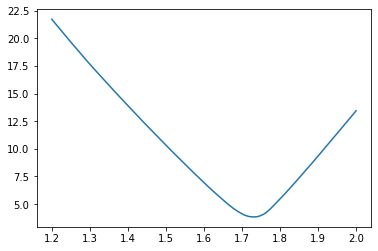

In [4]:
#don't attempt this on huge numbers of particles. Use a smaller number here like 100,000
from joblib import Parallel,delayed
import multiprocess
import scipy.interpolate as spi

#find circle of least confusion location
swarmTestMin=Swarm()
swarmTestMin.particles=swarmTraced.particles[:100_000]
interpFunctionMin=Interpolater(swarmTestMin,PTL)
xArr=np.linspace(1.2,2.,300)
frac=.9 #fraction to define circle

def circleRadius(x):
  xCoords,yCoords=interpFunctionMin(x)
  r=np.sqrt(xCoords**2+yCoords**2)
#   return np.std(r)
  r=np.sort(r)
  assert len(r)>10 
#   print(int(frac*len(r)))
  rCutoff=r[int(frac*len(r))]
  return 1e3*rCutoff

multiprocess.set_start_method('fork',force=True)
t=time.time()
with multiprocess.Pool(10) as pool:
    circleRadiusArr=np.asarray(pool.map(circleRadius,xArr))
interpFunc=spi.RBFInterpolator(xArr[:,np.newaxis],circleRadiusArr)
  

xArrDense=np.linspace(xArr[0],xArr[-1],10000)
yArrDense=interpFunc(xArrDense[:,np.newaxis])

xMin=xArrDense[np.argmin(yArrDense)]

print(xMin,np.min(yArrDense)) #1.721012101210121 4.2669987680085395
print(time.time()-t) 

plt.plot(xArr,circleRadiusArr)
# plt.plot(xArrDense,yArrDense,c='r')
plt.show()



1119 1.0


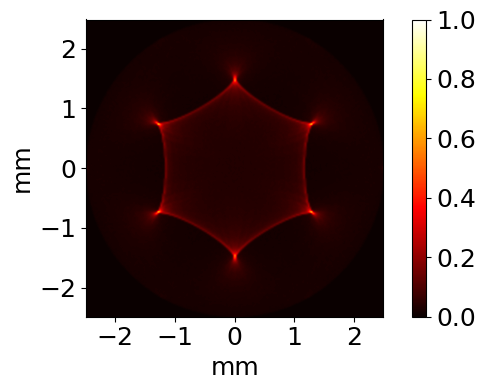

In [5]:
# %matplotlib tk
yArr,zArr=interpFunction(xMin)
yArr*=1e3
zArr*=1e3
rArr=np.sqrt(yArr**2+zArr**2)
rMax=2.5 #mm
yArr=yArr[rArr<rMax]
zArr=zArr[rArr<rMax]
image,yBins,zBins=np.histogram2d(yArr,zArr,bins=200)
image=image/image.max()     
print(int(image.sum()),image.max()) 
yMin=yBins[0]+(yBins[1]-yBins[0])/2
yMax=yBins[-1]-(yBins[1]-yBins[0])/2
zMin=zBins[0]+(zBins[1]-zBins[0])/2
zMax=zBins[-1]-(zBins[1]-zBins[0])/2
plt.figure(dpi=100)
plt.imshow(image,extent=[zMin,zMax,yMin,yMax],cmap='hot',interpolation='bicubic')#,vmin=0.0,vmax=25.6/10.0)
plt.xlabel('mm',fontsize=18)
plt.ylabel('mm',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
bar=plt.colorbar()
bar.ax.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig('focusImage')
plt.show()



1.1782190594887088


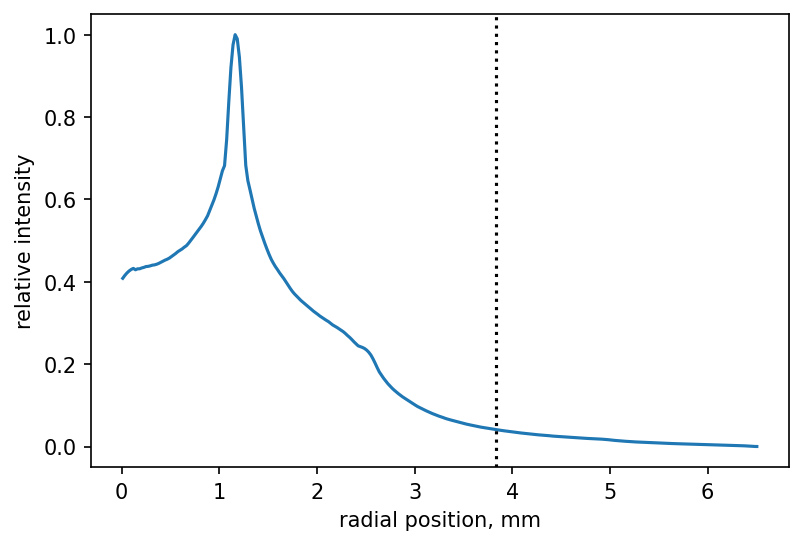

In [6]:
yArr,zArr=interpFunction(xMin)
yArr*=1e3
zArr*=1e3
rArr=np.sqrt(yArr**2+zArr**2)
print(np.std(rArr))

vals,bins=np.histogram(rArr,bins=300)
# The vals here are basically integreated flux
import scipy.signal as sps
binSize=bins[1]-bins[0]
rBinArr=bins[:-1]+binSize/2
radiusWeight=1/(rBinArr*binSize*2*np.pi)


vals=vals*radiusWeight
smoothStartDistance=-1
vals[:smoothStartDistance]=sps.savgol_filter(vals[:smoothStartDistance],11,2)
vals=vals/vals.max()

rLeastConfuse=circleRadius(xMin)

plt.figure(dpi=150)
plt.plot(rBinArr,vals)
plt.xlabel('radial position, mm')
plt.ylabel('relative intensity')

plt.axvline(x=rLeastConfuse,c='black',linestyle=':')
plt.savefig("focusIntensity")
plt.show()

## analyze flourescence signal
This if kind of crappy. Not worked out yet

In [7]:
swarmTracer=SwarmTracer(PTL)
t=time.time()
def initialize_Nozzle_Swarm(T,numParticles,xQuit=0.0,xOffset=0.0):
    #this uses the quitting surface concept
    swarm=swarmTracer.initalize_PseudoRandom_Swarm_In_Phase_Space(1e-6,.1*210.0,1e-6,numParticles,circular=True)
    sigma=91*np.sqrt(T/7.0)
    for particle in swarm:
        particle.q[0]+=-xOffset
        dt=-(xQuit-xOffset)/particle.p[0]
        particle.q=particle.p*dt+particle.q
        particle.p+=np.random.normal(scale=sigma)

    aperturePosition=16e-2
    apertureDiam=2.54e-2
    swarmTrimmed=Swarm()
    for particle in swarm:
        dt=(-aperturePosition-particle.q[0])/particle.p[0]
        qTest=particle.q+particle.p*dt
        r=np.sqrt(qTest[1]**2+qTest[2]**2)
        if r<apertureDiam/2:
            swarmTrimmed.particles.append(particle)
    assert swarmTrimmed.num_Particles()>10
    return swarmTrimmed
swarm=initialize_Nozzle_Swarm(5e-3,25_000,1e-12,xOffset=0.0)
swarm=swarmTracer.trace_Swarm_Through_Lattice(swarm,1e-6,1.0,fastMode=True,accelerated=True,parallel=False)
print(time.time()-t)
# file=open('swarmLens','wb')
# dill.dump(swarm,file)
# file=open('swarmLens','rb')
# swarm=dill.load(file)

# PTL.show_Lattice(swarm=swarm,showTraceLines=True,trueAspectRatio=False)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+40528=40528. 
  warnings.warn("The balance properties of Sobol' points require "


AttributeError: 'Particle' object has no attribute 'q'

In [ ]:
class Interpolater:
    def __init__(self,swarm,PTL):
        self.swarm=swarm
        self.PTL=PTL
        self.endDriftLength=abs(self.PTL.elList[-1].r2[0]-self.PTL.elList[-1].r1[0])
    def __call__(self,xOrbit):
        assert -self.PTL.elList[-1].r2[0]>xOrbit>-self.PTL.elList[-1].r1[0]
        yList=[]
        for particle in self.swarm:
            if particle.q[0]<-xOrbit:
                stepFrac=(abs(particle.q[0])-xOrbit)/self.endDriftLength
                ySlope=particle.p[1]/particle.p[0]
                y=particle.q[1]+stepFrac*self.endDriftLength*ySlope
                yList.append(y)
        return yList
interp=Interpolater(swarm,PTL)

In [ ]:
xTest=-np.linspace(PTL.elList[-1].r1[0]-1e-3,PTL.elList[-1].r2[0]+1e-3,100)
xTest=np.sort(xTest)
# xTest=xTest[xTest<1.8]
RMS_SpotSizeList=[]
COLC_List=[]
probeData=[]
for x in xTest:
    probeData=interp(x)
    RMS_SpotSizeList.append(np.std(probeData))
    COLC=np.sort(probeData)[int(len(probeData)*.9)]
    COLC_List.append(COLC)
    
plt.plot(xTest,RMS_SpotSizeList)
plt.show()

plt.plot(xTest,COLC_List)
plt.show()

In [ ]:
import scipy.optimize as spo
def flor_Profile_fit(x,a,gamma):
    return a*(gamma/2)**2/(x**2+(gamma/2)**2)
def get_Flor_Data(probeData,normalize=False):
    binNum=500
    data=np.histogram(probeData,bins=binNum)
    x=data[1][:-1]+(data[1][1]-data[1][0])/2
    sig=data[0]
    if normalize==True: sig=sig/sig.max()
    return x,sig
def fit_Data(probeData,normalize=False):
    x,sig=get_Signal_Data(probeData,normalize=normalize)
    guess=[sig.max(),.001]
    params=spo.curve_fit(fit,x,sig,p0=guess)[0]
    return params
fwhmList=[]
def get_FWHM(xEval,plot=False):
    assert isinstance(xEval,float) or isinstance(xEval,int) or len(xEval)==1
    probeData=interp(xEval)
    params=fit_Data(probeData)
    if plot==True:
        fwhmList.append(1e3*params[1])
        x,sigData=get_Signal_Data(probeData)
        xPlot=np.linspace(x[0],x[-1],1000)
        plt.title(str(xEval)+' '+str(1e3*params[1]))
        plt.plot(x,sigData)
        plt.plot(xPlot,fit(xPlot,*params))
        plt.show()
    return 1e3*params[1]


In [ ]:
temp=[]
for x in xTest[20:-20]:
    temp.append(get_FWHM(x,plot=False))
plt.plot(xTest[20:-20],temp)
plt.show()
min(temp)

In [ ]:
get_FWHM(sol.x,plot=True)

In [ ]:
# def get_Flor_Data(xEval,T,numParticles,xQuit,normalize=False):
#     swarm=initialize_Nozzle_Swarm(T,numParticles,xQuit)
#     swarm=swarmTracer.trace_Swarm_Through_Lattice(swarm,1e-5,1.0,fastMode=True,accelerated=True
#                                                   ,parallel=False,copySwarm=False)
    
#     interp=Interpolater(swarm,PTL)
#     data=interp.yInterp(xEval)
#     binNum=500
#     data=np.histogram(data,bins=binNum)
#     x=data[1][:-1]+(data[1][1]-data[1][0])/2
#     sig=data[0]
#     if normalize==True: sig=sig/sig.max()
#     return x,sig
# def get_Signal_Profile(x0,T,xQuit):
#     data=get_Probe_Data(x0,T,10_000,xQuit)
#     x,sig=get_Signal_Data(data,normalize=True)
#     return x,sig
#     params=fit_Data(data,normalize=True)
# def fit_Cost(X,x0=1.65):
#     T,xQuit=X
#     x,sig=get_Flor_Data(x0,T,25_000,xQuit,normalize=True)
#     guess=[sig.max(),.001]
#     params=spo.curve_fit(fit,x,sig,p0=guess)[0]
    
#     fitResult=fit(x,*params)
#     cost=np.sum((fitResult-sig)**2)
# #     plt.plot(x,sig)
# #     plt.plot(x,fit(x,*params))
# #     plt.show()
#     return cost

    
    
    
# bounds=[(1e-6,20e-3),(1e-3,15e-2)]
# # sol=spo.differential_evolution(fit_Cost,bounds,disp=False)
# # sol
# # fit_Cost([1e-3,.1])
# spo.minimize(fit_Cost,x0=[10e-3,.1],bounds=bounds,method='Nelder-Mead',options={'maxfev':100,'disp':True})

In [ ]:
plt.imshow(image)
image.max()

In [ ]:
T,xQuit=sol.x
x0=1.65
data=get_Probe_Data(x0,T,10_000,xQuit)
params=fit_Data(data,normalize=True)
x,sig=get_Signal_Data(data,normalize=True)
guess=[sig.max(),.001]
params=spo.curve_fit(fit,x,sig,p0=guess)[0]
fitResult=fit(x,*params)
plt.plot(x,sig)
plt.plot(x,fitResult)
plt.show()

In [ ]:
temp=np.asarray([1.455,1.378,1.379,1.377,1.377,1.377,1.377])
np.std(temp)/np.sqrt(6)

In [ ]:
results0=np.asarray([slowFunction(arg) for arg in argsArr])

In [ ]:
def slowFunction(x):
  a=np.sin(x)
  b=np.ones((1000,2000))*np.pi
  for y in range(10000):
    y=float(y)
    a+=np.sin(y+a)*np.arctan(y)
  return a+np.mean(b)



# t=time.time()
# for _ in range(100):
#   slowFunction(1)
# print(time.time()-t)

tList=[]
resultsList=[]
nArr=np.arange(1,20)
for n in nArr:
  argsArr=np.linspace(0,10,100)
  t=time.time()
  with pa.pools.ProcessPool(n) as pool:
    results=np.asarray(pool.map(slowFunction,argsArr))
#   print(time.time()-t)
#   print(np.sum(np.abs(results0-results)))
  tList.append(time.time()-t)
plt.plot(nArr,tList)
plt.show()

In [ ]:
particle=swarmTraced.particles[0]
from ParticleClass import Particle

t=time.time()
for particle in swarmTraced.particles:
  newParticle=Particle()
  for k,v in vars(particle).items():
      setattr(newParticle,k,v)
print(time.time()-t)

# keys=vars(particle).keys()
# vals=vars(particle).values()
# d1=vars(newParticle)
# d2=vars(particle)
# d2=d1
vars(newParticle)

In [ ]:
keys=vars(swarmTraced.particles[0]).keys()
for key,val in zip(keys,vars(swarmTraced.particles[0]).values()):
  print(val)

In [ ]:
for key,val in vars(swarmInitial.particles[0]).items():
  print(key,val)



In [ ]:
vars(swarmInitial.particles[0]).values